# Industrial pump vibrartions forecast

In [ ]:
# In the following, I intend to first look deep into the sensor data, the recorded vibration voltage of an industrial pump. 
# Second I will go on with different approaches to model the data and forecast the vibrations (consequently the status
# of the machine) in future.

In [2]:
# Importing required libraries:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

In [3]:
# Loading the data:
pump = pd.read_csv("E:\Github\project_pump.csv", error_bad_lines=False, sep='[;,]', header=None, engine = 'python')

In [4]:
pump = pd.DataFrame(pump, index=range(pump.shape[0]))
pump = pd.DataFrame(pump, columns=range(pump.shape[1]))

In [5]:
# I will check different properties of the data first:
pump.shape[0]

882

In [6]:
pump.index

RangeIndex(start=0, stop=882, step=1)

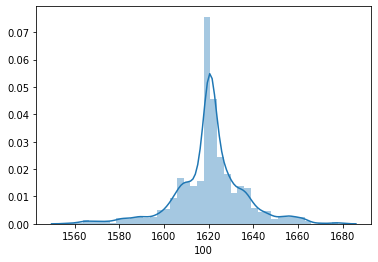

In [7]:
# Taking a look at the distribution of the signal, using seaborn library:
%matplotlib inline
sns.distplot(pump[100],kde = True, bins=40)

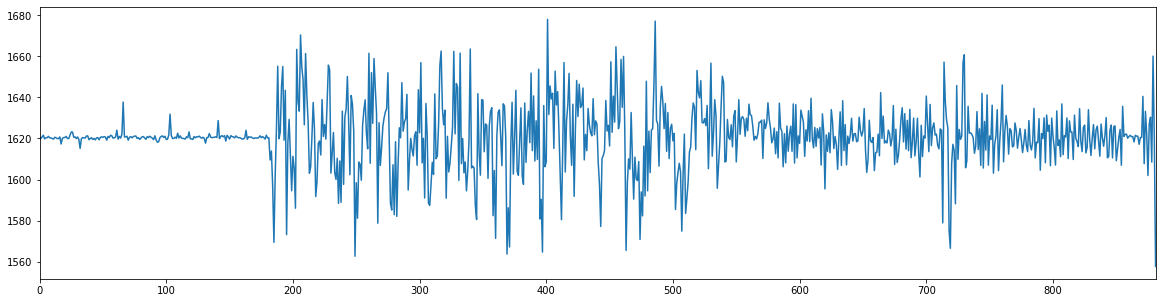

In [8]:
# I take a look at a row, as a vibration signal sample, visually: 
pump[100].plot.line(label='Pump Vibration Sig', figsize=(20, 5))

In [9]:
pump.drop([0,1,2,3,4,16387],axis=1, inplace=True)

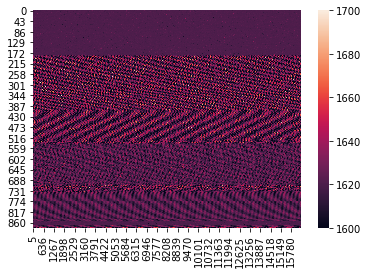

In [10]:
sns.heatmap(pump, vmin=1600, vmax=1700)

In [11]:
corpump = pump.corr(method='pearson')

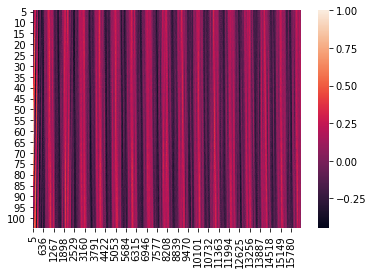

In [12]:
sns.heatmap(corpump[:100])

In [11]:
# I try another approach to calculate the auto-correlation of the signal:
laggmax = 100
corFunc = np.zeros(laggmax,dtype=float)

for lagg in range(0, 100):
    corFunc[lagg] = pump[100].autocorr(lag=lagg)

Text(0, 0.5, 'Auto-correlation-function')

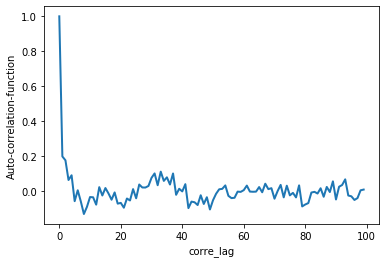

In [12]:
# And then I plot the auto-correlation function which shows that the signal is short-range correlated:
import matplotlib.pyplot as plt
plt.plot(corFunc, linewidth = 2.0)
plt.xlabel('corre_lag')
plt.ylabel('Auto-correlation-function')

In [13]:
corFunc

array([ 1.        ,  0.19761035,  0.17544435,  0.06263803,  0.08970426,
       -0.05869714,  0.00378748, -0.06015321, -0.1321545 , -0.09086137,
       -0.03504987, -0.03639218, -0.07847935,  0.02169153, -0.02604925,
        0.01659638, -0.01433483, -0.05022892, -0.0085414 , -0.07278185,
       -0.06838525, -0.09607848, -0.04333015, -0.05467335,  0.01044556,
       -0.04204019,  0.03681726,  0.01984755,  0.01945713,  0.02842948,
        0.07502247,  0.10034696,  0.03268335,  0.11047824,  0.05752171,
        0.0779009 ,  0.03668191,  0.10002254, -0.02211541,  0.01249664,
       -0.00281467,  0.03880411, -0.09838173, -0.06112617, -0.06483194,
       -0.08078802, -0.02475026, -0.07460751, -0.03605551, -0.10613685,
       -0.0533013 , -0.0162151 ,  0.00938557,  0.01184886,  0.03169173,
       -0.02803267, -0.04112272, -0.03913898, -0.0039714 , -0.00543623,
        0.00453536,  0.03061665, -0.00370672, -0.00473038, -0.00397384,
        0.02218699, -0.00763041,  0.04144006,  0.01034163,  0.01

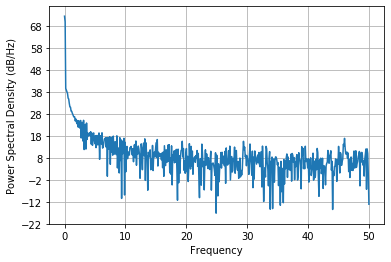

In [14]:
# Now I plot the power spectrum of the signal to find out the dominent frequencies, which might help us in further analysis:
%matplotlib inline
import matplotlib.pyplot as plt
dt = 0.01
power = plt.psd(pump[100], 1024, 1/dt)

# GARCH model

In [15]:
# Digging into the data, I can recommend the ARCH model for this data set (autoregressive conditional heteroskedasticity
# (ARCH model for volatility shocks) 
# This model as it is clear by it's name, models volatily, meaning different variances within the signal.
# As an example, applying the model on one of the samples pump[100]:

y_train = pump[100]

In [16]:
model = arch_model(y_train, vol='GARCH', p=20, o=1, q=20)

In [17]:
model_fit = model.fit()

Iteration:      1,   Func. Count:     45,   Neg. LLF: 3399.37896760363
Iteration:      2,   Func. Count:     91,   Neg. LLF: 3367.49825148183
Iteration:      3,   Func. Count:    137,   Neg. LLF: 3347.3415109786743
Iteration:      4,   Func. Count:    183,   Neg. LLF: 3337.025633788002
Iteration:      5,   Func. Count:    229,   Neg. LLF: 3331.3085401337203
Iteration:      6,   Func. Count:    275,   Neg. LLF: 3325.9372790583457
Iteration:      7,   Func. Count:    321,   Neg. LLF: 3324.5125925033662
Iteration:      8,   Func. Count:    367,   Neg. LLF: 3321.6049644585482
Iteration:      9,   Func. Count:    414,   Neg. LLF: 3321.2024141769143
Iteration:     10,   Func. Count:    460,   Neg. LLF: 3319.379269889002
Iteration:     11,   Func. Count:    506,   Neg. LLF: 3317.914160898849
Iteration:     12,   Func. Count:    552,   Neg. LLF: 3317.243419000243
Iteration:     13,   Func. Count:    598,   Neg. LLF: 3316.562499303098
Iteration:     14,   Func. Count:    644,   Neg. LLF: 3315.1

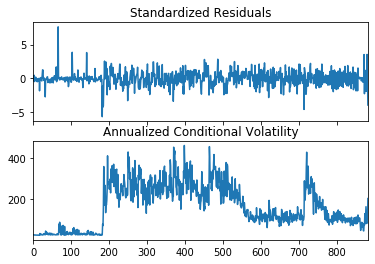

In [18]:
# To assess the model fit on the data, the standardized residuals and annualized conditional volatility are shown:
figure_model  = model_fit.plot(scale=160)

In [19]:
# One can plot a forcast using the model:
#yhat = model_fit.forecast(horizon=10)
#model_fit.summary()

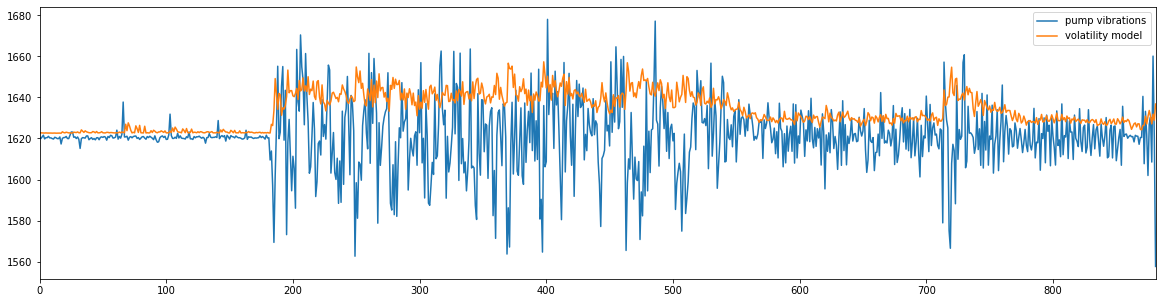

In [20]:
# On the other hand here I show that the variance volatility of the data is very well modeled by the data:
# yhat.variance.values
# y_train.rolling(5).var()+y_train.mean(), 'pump volatility'
df = pd.concat([y_train, model_fit.conditional_volatility+y_train.mean()],1)
df.columns = ['pump vibrations', 'volatility model']
subplot = df.plot(figsize=(20,5))

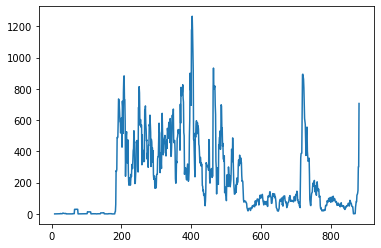

In [21]:
# The rolling varince of the data and the model could get compared to see how well it is matching:
variance = pump[100].rolling(10).var()
plt.plot(variance)
#plt.plot(yhat.variance.values[-10, :])
#yhat.variance.values

In [22]:
# Wavelet Analysis: locality of waves instead of global waves like in FFT:
#import pywt
#widths = np.arange(1, 31)
#cwtmatr, freqs = pywt.wt(pump[100], widths, 'mexh')

#plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
#...            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max()) 

# Linear Regression

In [23]:
# To model the vibrartion data one can use the Machine Learning Algorithm, Regression Analysis:

# First I split the data into training and test sets, so I can test the
# performance of the ML model I use. In order to do this the required
# library is imported from sklearn:

from sklearn.model_selection import train_test_split

In [24]:
y_train,y_test = pump.iloc[0:441,350], pump.iloc[441:882,350]

In [25]:
#yhat = model_fit.forecast(y_test)

In [26]:
# library is imported from sklearn to be able to split the data into train and test sets:
from sklearn.model_selection import train_test_split

In [27]:
# From sklearn, the linear models family, I choose Logistc Regression
# to use as the ML model:
from sklearn.linear_model import LinearRegression

In [28]:
# I organize the data first before modeling it:
newdfx = pd.DataFrame(pump.iloc[0:441,100]).reset_index(drop=True)
newdfy = pd.DataFrame(pump.iloc[441:882,100]).reset_index(drop=True)

In [29]:
newdf = pd.concat([newdfx, newdfy], axis = 1)

In [30]:
newdf.columns = ['xdata','ydata']
newdf

,xdata,ydata
0,1620.945740,1610.421753
1,1620.391846,1590.834045
2,1620.593262,1584.942627
3,1620.341492,1609.716797
4,1620.542908,1610.522461
5,1620.845032,1618.730164
6,1619.535828,1650.553894
7,1620.794678,1609.968567
8,1621.600342,1614.299011
9,1620.391846,1633.081055


In [31]:
x = newdf[['xdata']]
y = newdf['ydata']

In [32]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.33)

In [33]:
#from sklearn import preprocessing
#from sklearn import utils

#lab_enc = preprocessing.LabelEncoder()
#encoded_x_train = lab_enc.fit_transform(x_train)
#encoded_y_train = lab_enc.fit_transform(y_train)
#encoded_x_test = lab_enc.fit_transform(x_test)


In [34]:
#encoded_y_train = [encoded_y_train.tolist()]
#encoded_x_train = [encoded_x_train.tolist()]
#encoded_x_test = [encoded_x_test.tolist()]
x_test

,xdata
37,1620.895386
261,1599.192810
365,1611.730957
322,1609.313965
149,1622.758484
78,1622.204590
212,1632.527161
209,1622.758484
267,1585.949707
192,1667.170715


In [35]:
# Here I start with firing a LR model to the training data:
linReg = LinearRegression()

In [36]:
linReg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
# Now I make predictions using the fitted model:
predictions = linReg.predict(pump[[100]])

In [46]:
#plt.scatter(y_test, predictions)
y.size

441

In [47]:
# to assess the model, we import the suitable metrics:
from sklearn import metrics
metrics.explained_variance_score(pump[100],predictions)

0.2718035822777918

In [48]:
predictions.shape

(882,)

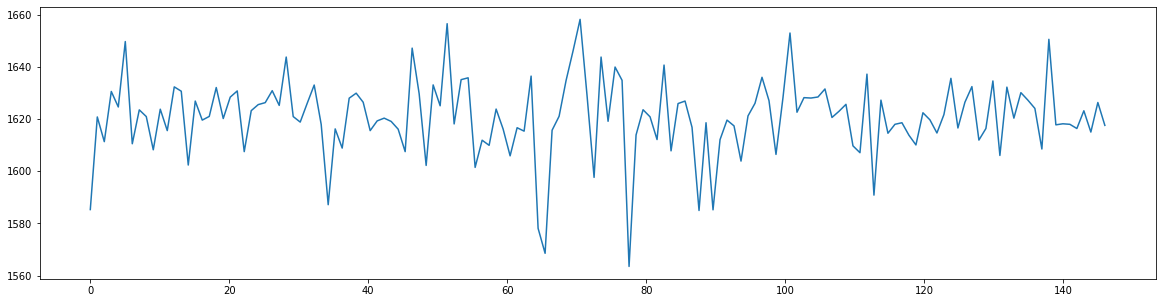

In [54]:
# Here I plot the model and the test data for us to see how well it fits:
t = np.linspace(0, 146, 146)

plt.figure(figsize=(20,5))
#plt.plot(t, predictions)
plt.plot(t, y_test)

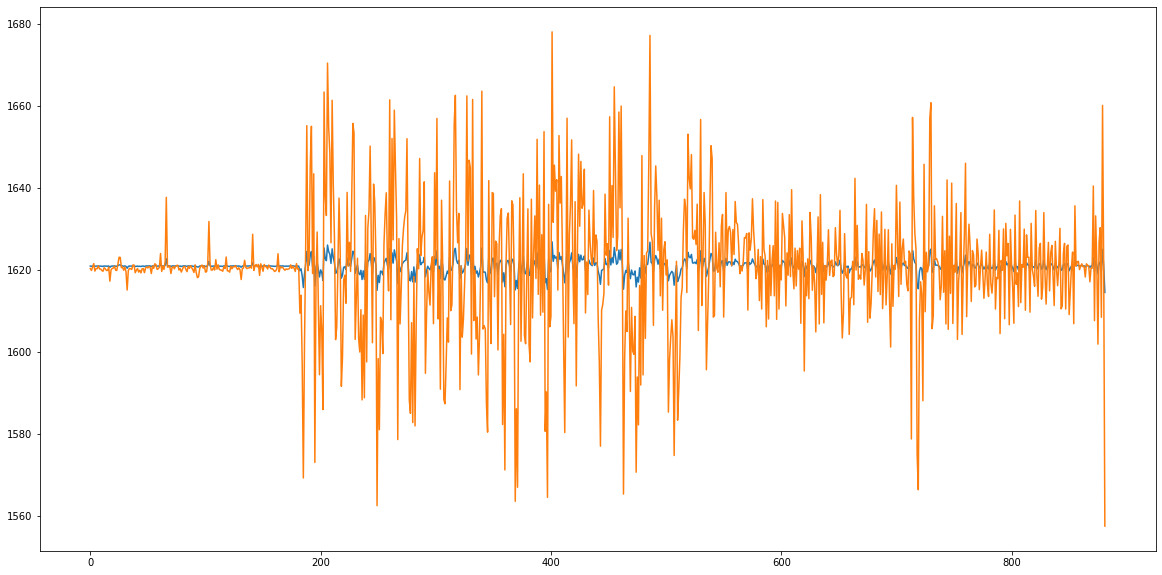

In [47]:
# Plotting the predictions (model), over the whole data set, we see that the model nicely captures the variance volatility:
plt.figure(figsize=(20,10))
plt.plot(predictions)
plt.plot(pump[100])
